# Playground code

## Import libraries

In [1]:
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.utils.visualize_util import plot
from keras.callbacks import Callback


import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import numpy as np
import seaborn as sms
import sklearn

Using TensorFlow backend.


# Step 0 - Load and Exploration

## Use Pandas for visualization

The initial exploration below shows that initial dataset have about 3x3.3K = 10K images only, I will further augment this data but I was surprised by the achievements with such small dataset. For this track I have been using my CPU machine for both dataset collection and model training.

1 - I have collected my data from 'fastest' mode from Udacity simulator. Which does not include shadows on the road.

2 - I have collected images for 3 full cycles driving in the correct direction only. So data is expected to be biased for curves in one side.

3 - I have used the keyboard arrows to drive, so the data is not smooth and have a lot s=0 because you dont hold the arrow to keep constant small angles.

4 - I tried to keep the car in the center all the time.

5 - I did not collected data with the car recovering itself from off the road. That could be future data improvements.

It shows that the steering angle (s) is between about [-0.9,0.8]. Small steering angle around 0 seems to have the highest frequency which aligns with the ideia that most of the time the car is not steering during drive experience, but we are going to check it in detail later. 

In [2]:
drive_log_df = pd.read_csv('data/driving_log.csv', skipinitialspace=True)
print('Table shape: ', drive_log_df.shape)
print('Columns: ', drive_log_df.columns.values)
print('Steering stats:')
print(drive_log_df.steering.describe())
drive_log_df.head()

Table shape:  (3343, 7)
Columns:  ['center' 'left' 'right' 'steering' 'throttle' 'brake' 'speed']
Steering stats:
count    3343.000000
mean       -0.034530
std         0.114299
min        -0.926023
25%        -0.037336
50%         0.000000
75%         0.000000
max         0.771690
Name: steering, dtype: float64


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2017_03_14_11_05_16_001.jpg,IMG/left_2017_03_14_11_05_16_001.jpg,IMG/right_2017_03_14_11_05_16_001.jpg,0.0,0.000000,0,0.000006
1,IMG/center_2017_03_14_11_05_16_084.jpg,IMG/left_2017_03_14_11_05_16_084.jpg,IMG/right_2017_03_14_11_05_16_084.jpg,0.0,0.000000,0,0.000001
2,IMG/center_2017_03_14_11_05_16_152.jpg,IMG/left_2017_03_14_11_05_16_152.jpg,IMG/right_2017_03_14_11_05_16_152.jpg,0.0,0.000000,0,0.000011
3,IMG/center_2017_03_14_11_05_16_219.jpg,IMG/left_2017_03_14_11_05_16_219.jpg,IMG/right_2017_03_14_11_05_16_219.jpg,0.0,0.000000,0,0.000006
4,IMG/center_2017_03_14_11_05_16_302.jpg,IMG/left_2017_03_14_11_05_16_302.jpg,IMG/right_2017_03_14_11_05_16_302.jpg,0.0,0.049821,0,0.026819


## Visualize a random center image

Below we can see that we are dealing with 160x320 images, 3 channels RGB. I have used cv2 to read the image, but it reads in the inverse order (BGR), so it requires a small trick to plot using matplotlib.

image shape: (160, 320, 3)


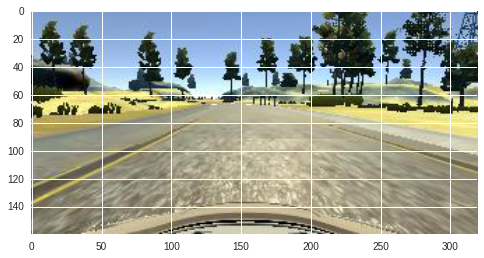

In [3]:
plt.figure(figsize=(10,4))
index = np.random.randint(0, drive_log_df.shape[0])
random_image = drive_log_df.iloc[index]
image = cv2.imread("./data/{0}".format(random_image.center))
print('image shape:', image.shape)
plt.figure(1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Visualize left, center and right images at same time step

Center, left and right images can be used to help the neural net learn how to steer but we cannot use the same steering value for all three cameras, because the recorded steering angle consider the reference at center position. When we input the image of the left camera in the neural net, it implies that the center of the car is at the left position, so we need to make the appropriate transformations in the steering angles. That will be executed later in preprocessing.


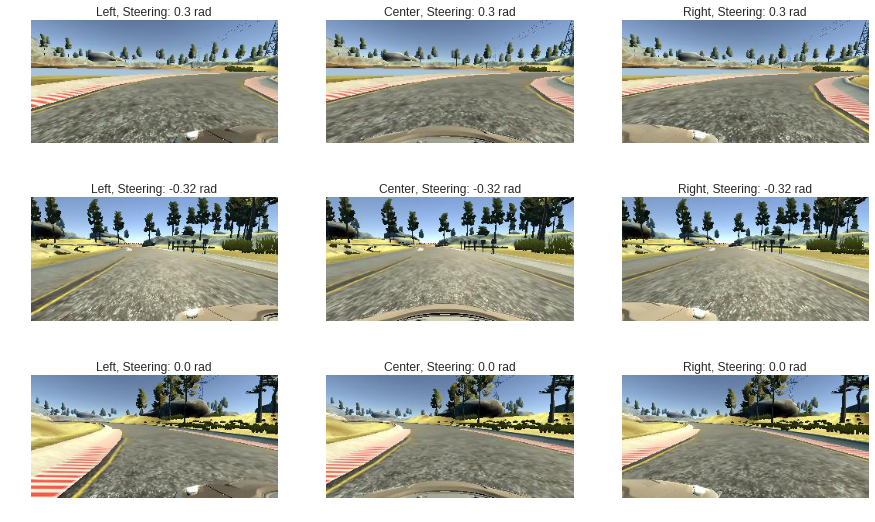

In [4]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

#  Plotting samples of the images
def plotsignal(images, nrows=1):
    """
    Plot images in a subplot arrangement.
    images = pandas dataframe with 'center', 'left', 'right' and 'steering' columns
    nrows = numbers of rows in the image plot arrangement
    """
    
    scalesize = 3*nrows*3
    f, axarr = plt.subplots(nrows, 3, figsize=(scalesize/(nrows*0.6), scalesize/3))
    axarr = axarr.ravel()
    for i in range(nrows):
        index = np.random.randint(0, len(images))
        random_image = images.iloc[index]
        image1 = cv2.imread("./data/{0}".format(random_image.left))
        image2 = cv2.imread("./data/{0}".format(random_image.center))
        image3 = cv2.imread("./data/{0}".format(random_image.right))
        axarr[3*i].axis('off')
        axarr[3*i].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
        axarr[3*i].set_title('Left, ' + 'Steering:' + ' ' + str(round(random_image.steering,2)) + ' rad')
        axarr[3*i+1].axis('off')
        axarr[3*i+1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
        axarr[3*i+1].set_title('Center, ' + 'Steering:' + ' ' + str(round(random_image.steering,2)) + ' rad')
        axarr[3*i+2].axis('off')
        axarr[3*i+2].imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))
        axarr[3*i+2].set_title('Right, ' + 'Steering:' + ' ' + str(round(random_image.steering,2)) + ' rad')

nrows = 3 # change it here the way you want, 0 will give error
plotsignal(drive_log_df, nrows)

## Visualize steering distribution

Here we can check in detail the steering distribution. It confirmed the huge bias to s=0 in the dataset.

Stats:
count    3343.000000
mean       -0.034530
std         0.114299
min        -0.926023
25%        -0.037336
50%         0.000000
75%         0.000000
max         0.771690
Name: steering, dtype: float64
s=0 Steering: 2339
s>0 Steering: 128
s<0 Steering: 876


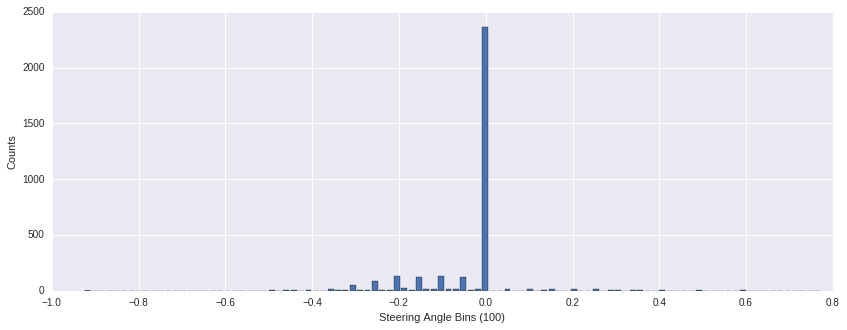

In [5]:
#  Plotting steering distribution
def plotSteering(images, figsize=[14,8]):
    """
    Plot steering distribution.
    images = pandas dataframe with 'steering' column
    figsize = 2D list
    """
    print("Stats:")
    print(images.steering.describe())
    print("s=0 Steering:", images.steering.iloc[images.steering.values==0].count())
    print("s>0 Steering:", images.steering.iloc[images.steering.values>0].count())
    print("s<0 Steering:", images.steering.iloc[images.steering.values<0].count())

    images.steering.hist(bins=100, rwidth=0.8, figsize=figsize)
    plt.xlabel('Steering Angle Bins (100)')
    plt.ylabel('Counts')
    plt.show()
    
plotSteering(drive_log_df, figsize=[14,5])

# Step 1 - Adjusting the dataset distribution

## Drop s=0 by 95% (norm dist)

I have started dropping 90% but 95% worked better.

Steering angle s=0 have the highest frequency, way high than other angle values. Also, there are a lot more negative (876 counts) than positive angle values (128 counts), which means the data has recorded way more curves to the left.

Stats:
count    1121.000000
mean       -0.102975
std         0.178685
min        -0.926023
25%        -0.200000
50%        -0.103205
75%        -0.020257
max         0.771690
Name: steering, dtype: float64
s=0 Steering: 117
s>0 Steering: 128
s<0 Steering: 876


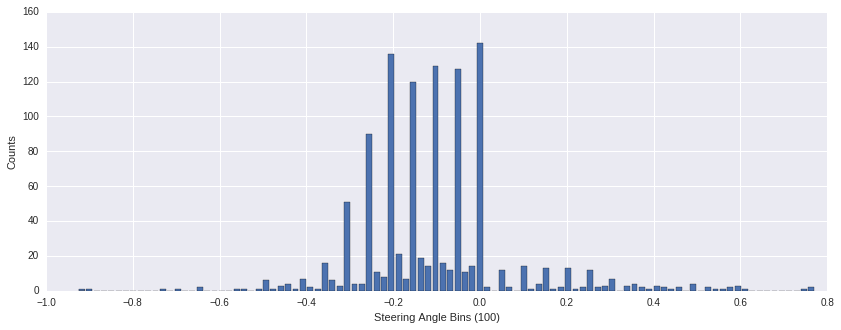

,center,left,right,steering,throttle,brake,speed
3337,IMG/center_2017_03_14_11_09_31_893.jpg,IMG/left_2017_03_14_11_09_31_893.jpg,IMG/right_2017_03_14_11_09_31_893.jpg,-0.300000,1.0,0,30.16997
3338,IMG/center_2017_03_14_11_09_31_992.jpg,IMG/left_2017_03_14_11_09_31_992.jpg,IMG/right_2017_03_14_11_09_31_992.jpg,-0.060648,1.0,0,30.19044
3339,IMG/center_2017_03_14_11_09_32_060.jpg,IMG/left_2017_03_14_11_09_32_060.jpg,IMG/right_2017_03_14_11_09_32_060.jpg,-0.100000,1.0,0,30.19056
3340,IMG/center_2017_03_14_11_09_32_130.jpg,IMG/left_2017_03_14_11_09_32_130.jpg,IMG/right_2017_03_14_11_09_32_130.jpg,-0.250000,1.0,0,30.18016
3341,IMG/center_2017_03_14_11_09_32_209.jpg,IMG/left_2017_03_14_11_09_32_209.jpg,IMG/right_2017_03_14_11_09_32_209.jpg,-0.038463,1.0,0,30.19079


In [6]:
def drop_s0(df, percentage=0.90):    
    # map percentage of zero steering random samples for drop
    zero_steering = df[df.steering == 0].sample(frac=percentage)
    
    return df.drop(zero_steering.index)

# Test it
new_drive_log = drop_s0(drive_log_df, percentage=0.95)
plotSteering(new_drive_log, figsize=[14,5])
new_drive_log.tail()

## Left and right steering angles correction


Great explanations how to best adjust the steering angles applying a dynamic offset and avoid the 'drunk' drive in high speed:
https://hoganengineering.wixsite.com/randomforest/single-post/2017/03/13/Alright-Squares-Lets-Talk-Triangles
https://hoganengineering.wixsite.com/randomforest/single-post/2017/03/14/How-To-Triangle

For now I have applied a simplified version of the dynamic offset correction and worked good enough for my model. Later on I can come back to this model and further improve it. 

Stats:
count    3363.000000
mean       -0.102975
std         0.223782
min        -2.117245
25%        -0.200000
50%        -0.089009
75%        -0.007038
max         1.623380
Name: steering, dtype: float64
s=0 Steering: 117
s>0 Steering: 680
s<0 Steering: 2566


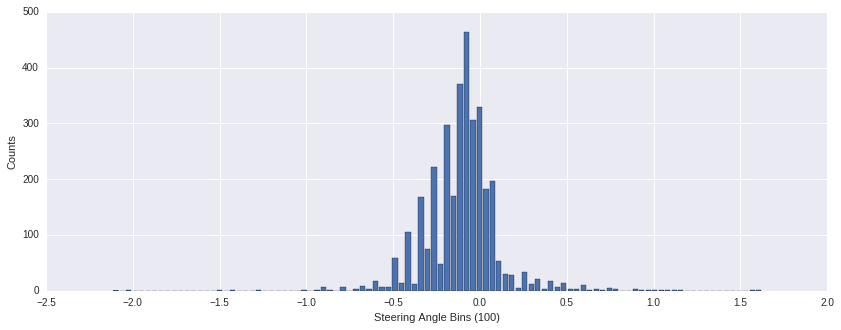

,image,steering
3358,IMG/right_2017_03_14_11_09_32_130.jpg,-0.410991
3359,IMG/center_2017_03_14_11_09_32_130.jpg,-0.250000
3360,IMG/left_2017_03_14_11_09_32_209.jpg,0.043454
3361,IMG/right_2017_03_14_11_09_32_209.jpg,-0.120380
3362,IMG/center_2017_03_14_11_09_32_209.jpg,-0.038463


In [7]:
# This is a modified version of function created by Mez Gebre
# https://mez.github.io/deep%20learning/2017/02/14/mainsqueeze-the-52-parameter-model-that-drives-in-the-udacity-simulator/
def update_left_right_steering_correction(df, offset=0.1):
    max_steer = df.steering.max()
    records = []
    for index, row in df.iterrows():
        left = row.left
        center = row.center
        right = row.right
        steering = row.steering

        records.append({
            'image': left,
            'steering': steering +  ((steering * steering / max_steer ) + offset)
        })

        records.append({
            'image': right,
            'steering': steering -  ((steering * steering / max_steer ) + offset)
        })

        records.append({
            'image': center,
            'steering': steering
        })

    
    return pd.DataFrame(data=records, columns=['image', 'steering'])

# Test it
new_drive_log = update_left_right_steering_correction(new_drive_log, offset=0.08)
plotSteering(new_drive_log, figsize=[14,5])
new_drive_log.tail()

### Here are some images with the steering corretions

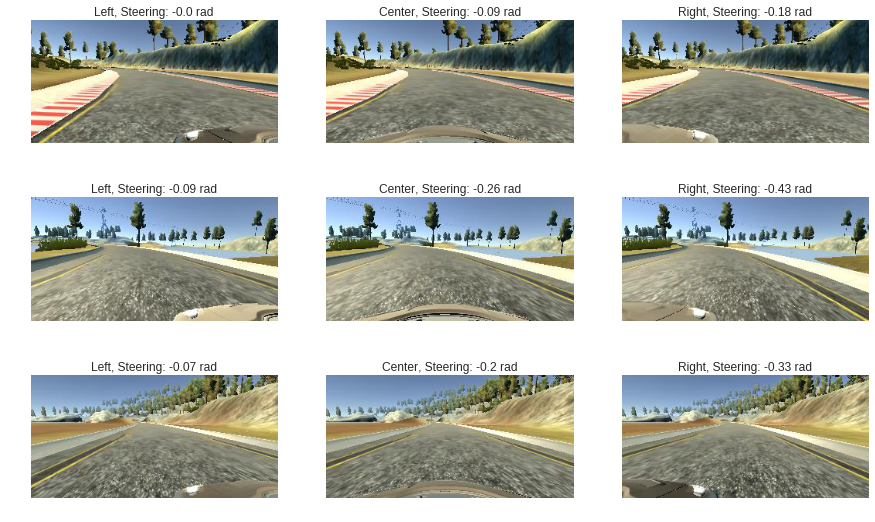

In [8]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

#  Plotting samples of the images
def plotsignal_2(images, nrows=1):
    """
    Plot images in a subplot arrangement.
    images = pandas dataframe with 'image' and 'steering' columns
    nrows = numbers of rows in the image plot arrangement
    """
    
    scalesize = 3*nrows*3
    f, axarr = plt.subplots(nrows, 3, figsize=(scalesize/(nrows*0.6), scalesize/3))
    axarr = axarr.ravel()
    for i in range(nrows): 
        find_left = -1
        while find_left == -1:
            index = np.random.randint(0, len(images)-2)
            str1 = new_drive_log.iloc[index].image
            find_left = str1.find('left')             

        random_image1 = images.iloc[index]
        random_image2 = images.iloc[index+2]
        random_image3 = images.iloc[index+1]
        image1 = cv2.imread("./data/{0}".format(random_image1.image))
        image2 = cv2.imread("./data/{0}".format(random_image2.image))
        image3 = cv2.imread("./data/{0}".format(random_image3.image))
        axarr[3*i].axis('off')
        axarr[3*i].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
        axarr[3*i].set_title('Left, ' + 'Steering:' + ' ' + str(round(random_image1.steering,2)) + ' rad')
        axarr[3*i+1].axis('off')
        axarr[3*i+1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
        axarr[3*i+1].set_title('Center, ' + 'Steering:' + ' ' + str(round(random_image2.steering,2)) + ' rad')
        axarr[3*i+2].axis('off')
        axarr[3*i+2].imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))
        axarr[3*i+2].set_title('Right, ' + 'Steering:' + ' ' + str(round(random_image3.steering,2)) + ' rad')       
        
        
nrows = 3 # change it here the way you want, 0 will give error
plotsignal_2(new_drive_log, nrows)


## Flipping and reverse of steering angle

Stats:
count    6.609000e+03
mean     8.600911e-18
std      2.484973e-01
min     -2.117245e+00
25%     -1.097002e-01
50%      0.000000e+00
75%      1.097002e-01
max      2.117245e+00
Name: steering, dtype: float64
s=0 Steering: 117
s>0 Steering: 3246
s<0 Steering: 3246


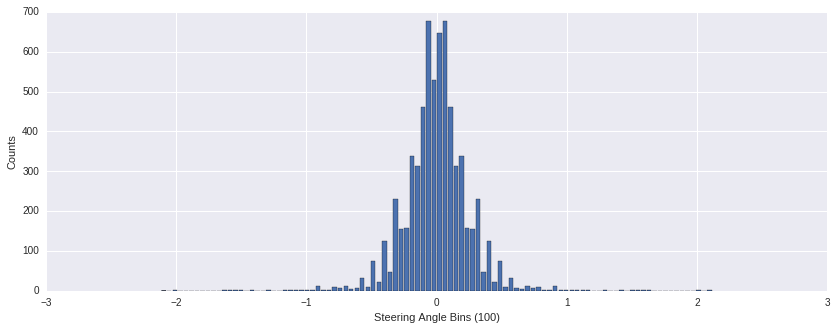

,image,steering,is_flipped
1712,IMG/center_2017_03_14_11_07_25_197.jpg,0.154128,True
614,IMG/center_2017_03_14_11_06_02_041.jpg,0.050000,True
1879,IMG/right_2017_03_14_11_07_44_417.jpg,0.254087,True
2604,IMG/left_2017_03_14_11_08_41_218.jpg,0.062389,True
2951,IMG/center_2017_03_14_11_09_09_309.jpg,0.250000,True


In [9]:
# This is a modified version of function created by Mez Gebre
# https://mez.github.io/deep%20learning/2017/02/14/mainsqueeze-the-52-parameter-model-that-drives-in-the-udacity-simulator/
def flip_images_augmentation(df, percentage=0.40):
    new_df = df[df.steering != 0].sample(frac=percentage)
    df.loc[:,'is_flipped'] = False
    new_df.loc[:,'is_flipped'] = True
    left_rows = (new_df.steering < 0)
    right_rows = (new_df.steering > 0)
    new_df.loc[left_rows,'steering'] = new_df[left_rows].steering.abs()
    new_df.loc[right_rows, 'steering'] = new_df[right_rows].steering * -1
    return pd.concat([df, new_df])

# Test it
new_drive_log = flip_images_augmentation(new_drive_log, percentage=1.00)
plotSteering(new_drive_log, figsize=[14,5])
new_drive_log.tail()

## Further augmentation by image horizontal shift

I did some experimentation but angle adjustment of about 0.004 per pixel shift really give better results. That range is suggested by:
Vivek Yadav
https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.nikqu6aas

Stats:
count    13101.000000
mean         0.000131
std          0.249179
min         -2.117245
25%         -0.131742
50%          0.000000
75%          0.132000
max          2.117245
Name: steering, dtype: float64
s=0 Steering: 118
s>0 Steering: 6514
s<0 Steering: 6469


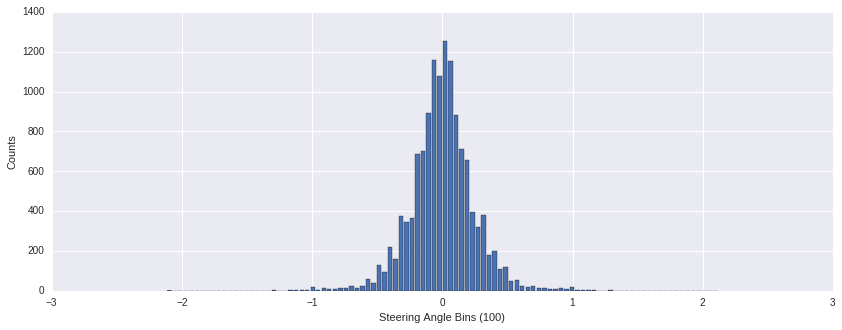

,image,steering,is_flipped,random_shift,is_shift
1712,IMG/center_2017_03_14_11_07_25_197.jpg,0.182128,True,7,True
614,IMG/center_2017_03_14_11_06_02_041.jpg,0.170000,True,30,True
1879,IMG/right_2017_03_14_11_07_44_417.jpg,0.190087,True,-16,True
2604,IMG/left_2017_03_14_11_08_41_218.jpg,0.122389,True,15,True
2951,IMG/center_2017_03_14_11_09_09_309.jpg,0.330000,True,20,True


In [10]:
# This is a modified version of function created by Mez Gebre
# https://mez.github.io/deep%20learning/2017/02/14/mainsqueeze-the-52-parameter-model-that-drives-in-the-udacity-simulator/
def shift_img_augmentation(df):
    df.loc[:,'random_shift'] = 0
    new_df = df[df.steering != 0].copy()
    df.loc[:,'is_shift'] = False
    new_df.loc[:,'is_shift'] = True
    
    
    max_shift = 30
    max_ang = 0.12
    
    def row_shift_update(row):
        random_shift = np.random.randint(-max_shift, max_shift + 1)
        row.random_shift = random_shift
        updated_steer = row.steering + (random_shift / max_shift) * max_ang
        if abs(updated_steer) > 1:
            updated_steer = -1 if (updated_steer < 0) else 1

        row.steering = updated_steer
        return row

    new_df = new_df.apply(row_shift_update, axis=1)
    return pd.concat([df, new_df])

# Test it
new_drive_log = shift_img_augmentation(new_drive_log)
plotSteering(new_drive_log, figsize=[14,5])
new_drive_log.tail()


## Let's record a balanced driver log

Stats:
count    13065.000000
mean        -0.000528
std          0.239618
min         -1.000000
25%         -0.132993
50%          0.000000
75%          0.133165
max          1.000000
Name: steering, dtype: float64
s=0 Steering: 122
s>0 Steering: 6431
s<0 Steering: 6512


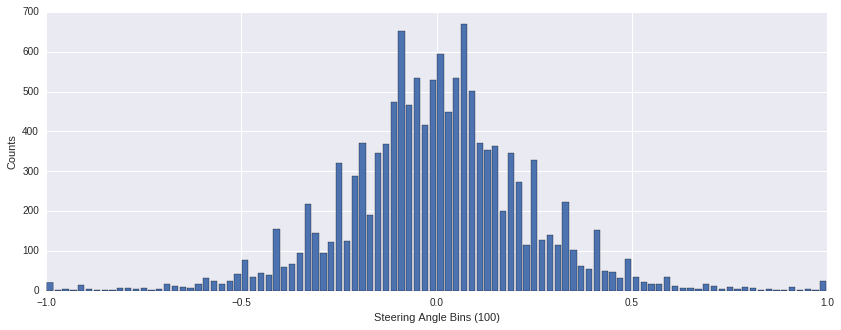

,image,steering,is_flipped,random_shift,is_shift
13096,IMG/right_2017_03_14_11_08_39_481.jpg,0.241240,True,27,True
13097,IMG/left_2017_03_14_11_06_32_485.jpg,-0.516627,True,-5,True
13098,IMG/center_2017_03_14_11_06_30_998.jpg,-0.262618,True,-4,True
13099,IMG/right_2017_03_14_11_07_12_588.jpg,0.199157,True,-15,True
13100,IMG/right_2017_03_14_11_06_52_887.jpg,0.187900,True,-14,True


In [11]:
# This is a modified version of function created by Mez Gebre
# https://mez.github.io/deep%20learning/2017/02/14/mainsqueeze-the-52-parameter-model-that-drives-in-the-udacity-simulator/
def process_driver_log(driver_log):
    update_log = drop_s0(driver_log, percentage=0.95)
    update_log = update_left_right_steering_correction(update_log, offset=0.08)
    update_log = flip_images_augmentation(update_log, percentage=1.0)
    update_log = shift_img_augmentation(update_log)
    
    #reset index since it's no longer good.
    update_log = update_log.reset_index(drop=True)
    
    #drop outbound steering examples to be between [-1,1]
    outbound_steering = update_log[abs(update_log.steering) > 1]
    update_log = update_log.drop(outbound_steering.index)

    return update_log

# Do it
processed_log = process_driver_log(drive_log_df)
plotSteering(processed_log, figsize=[14,5])
processed_log.tail()

## Let's generate the final driver log by trimming at certain uniform level 
After some experimenting I have decided to trim at 750 count for each of the 100 bins.
The code bellow basically generates a list of strings (as pandas dataframe) to mask the original driver log.

So I have ended up with almost 47K images dataset, ranging [-1,1], 23498 positves 23115 negatives. 

Stats:
count    12552.000000
mean        -0.000535
std          0.244099
min         -1.000000
25%         -0.135941
50%         -0.000693
75%          0.136097
max          1.000000
Name: steering, dtype: float64
s=0 Steering: 104
s>0 Steering: 6149
s<0 Steering: 6299


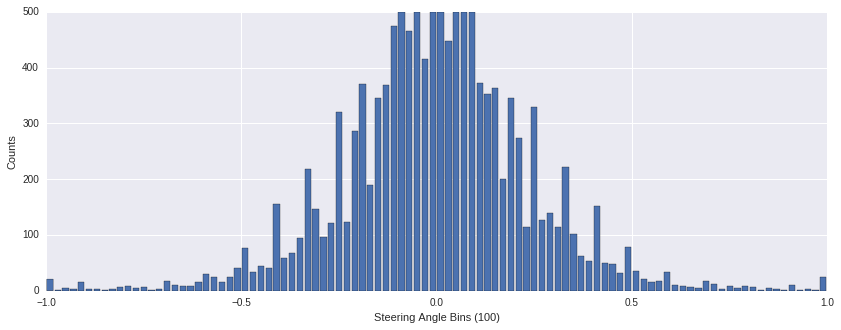

In [12]:
# This is a modified version of code created by Mez Gebre
# https://mez.github.io/deep%20learning/2017/02/14/mainsqueeze-the-52-parameter-model-that-drives-in-the-udacity-simulator/
hist, counts = np.histogram(processed_log.steering, bins=100)
upper_limit = 500
over = [(i, v) for i, v in enumerate(hist) if v > upper_limit ]
over_ranges = [(counts[i],counts[i+1]) for i,_ in over]
#loop through ranges and create a mask for each bin 
masks = []
for l,r in over_ranges:
    if r>=1:
        masks.append("processed_log[(processed_log.steering >= {0}) & (processed_log.steering <= {1})]".format(l,r))
    else:
         masks.append("processed_log[(processed_log.steering >= {0}) & (processed_log.steering < {1})]".format(l,r))


for mask in masks:
    selected = eval(mask)
    selected_length = len(selected)
    frac_to_drop = (selected_length-upper_limit)/selected_length
    samples_to_drop = selected.sample(frac=frac_to_drop)
    processed_log = processed_log.drop(samples_to_drop.index)

# Visualize
plotSteering(processed_log, figsize=[14,5])

In [13]:
# Record it
processed_log.to_csv('preprocessed_driver_log.csv')

# Step 2 - Image preprocess functions

Now that we have a decent distribution we can start the image preprocessing


## Crop images to get rid of landscape and car's hood (image noise) and resize image to same as used by NVIDIA NN Model 


(160, 320, 3)


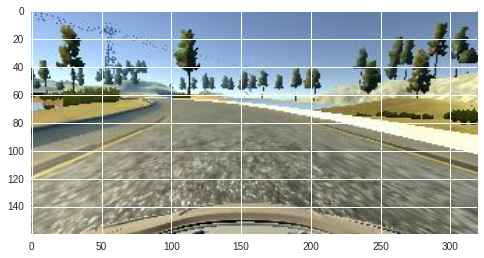

(66, 200, 3)


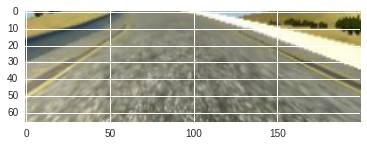

In [14]:
# This is a modified version of code created by Mez Gebre
# https://mez.github.io/deep%20learning/2017/02/14/mainsqueeze-the-52-parameter-model-that-drives-in-the-udacity-simulator/
def crop_top_and_bottom(image):
    resized = cv2.resize(image[67:135], (200,66),  cv2.INTER_AREA)
    #resized = cv2.cvtColor(resized, cv2.COLOR_RGB2HSV)[:,:,1] #in case want to convert to 1 channel
    return resized

# Test it
plt.figure(figsize=(10,4))
random_image = drive_log_df.iloc[548]
image = cv2.imread("./data/{0}".format(random_image.center))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
plt.figure(1)
plt.imshow(image)
plt.show()

cropped_image = crop_top_and_bottom(image)
print(cropped_image.shape)
plt.figure(2)
plt.imshow(cropped_image)
plt.show()

In [15]:
#  Plotting same image preprocessing for effect comparison
def plotPreprocessing(images, nrows=1, ncols=1, prefix_label = 'label:'):
    """
    Plot images in a subplot arrangement.
    images = 4D array containing raw pixel data of the images, (num examples, width, height, channels)
    nrows = numbers of rows in the image plot arrangement
    ncols = numbers of columns in the image plot arrangement
    prefix_label = prefix label to show on top of images
    """
    scalesize = 3*nrows*ncols
    f, axarr = plt.subplots(nrows, ncols, figsize=(scalesize/(nrows*0.6), scalesize/ncols))
    if (nrows != 1) and (ncols != 1): # Take care of error in case nrows/ncols = 1
        axarr = axarr.ravel()
    if (nrows == 1) and (ncols == 1): # Take care of error in case both nrows/ncols = 1
        axarr.axis('off')
        axarr.imshow(images[0])
        axarr.set_title(prefix_label)
    else:
        for i in range(nrows*ncols):
            axarr[i].axis('off')
            axarr[i].imshow(images[i])
            axarr[i].set_title(prefix_label)

## Apply random brightness adjustments (augmentation)

images shape: (12, 160, 320, 3)


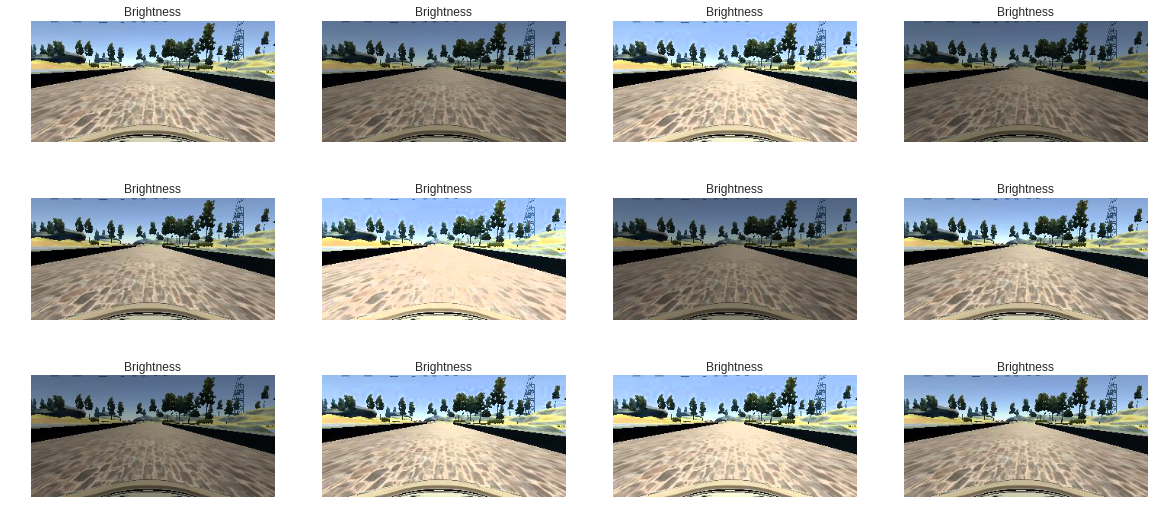

In [16]:
# Vivek Yadav
# https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.nikqu6aas
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1


# Test it 
index = np.random.randint(0, drive_log_df.shape[0])
random_image = drive_log_df.iloc[index]
image = cv2.imread("./data/{0}".format(random_image.center))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
images = []
for i in range(12):
    images.append(augment_brightness_camera_images(image))
images = np.array(images)    

print('images shape:', images.shape)
plotPreprocessing(images, nrows=3, ncols=4, prefix_label = 'Brightness')


## Apply random shadows (augmentation)

images shape: (12, 160, 320, 3)


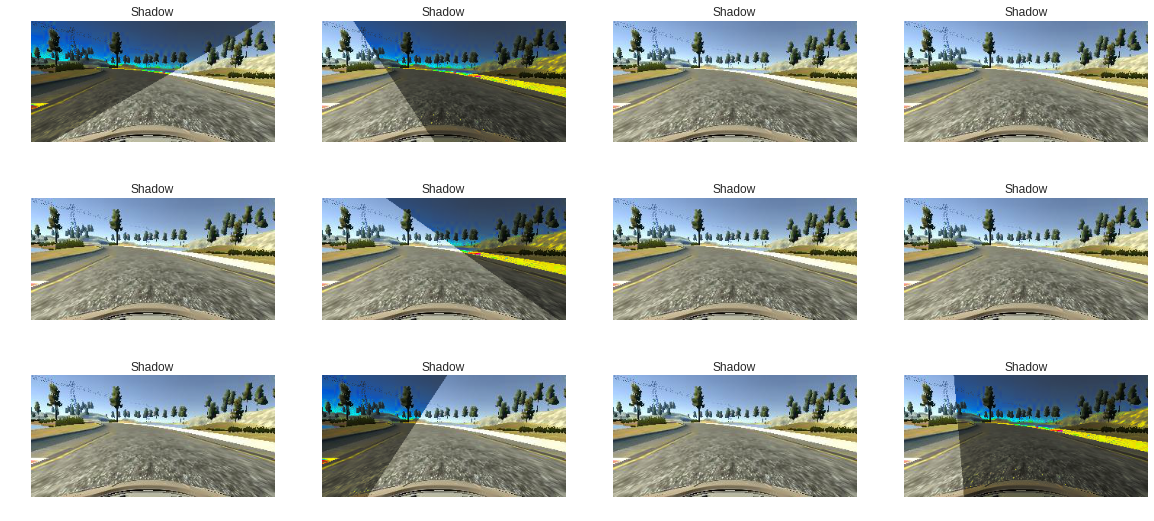

In [17]:
# Vivek Yadav
# https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.nikqu6aas
def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image


# Test it 
index = np.random.randint(0, drive_log_df.shape[0])
random_image = drive_log_df.iloc[index]
image = cv2.imread("./data/{0}".format(random_image.center))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
images = []
for i in range(12):
    images.append(add_random_shadow(image))
images = np.array(images)   

print('images shape:', images.shape)
plotPreprocessing(images, nrows=3, ncols=4, prefix_label = 'Shadow')

## Flipping, horizontal shift and load methods

Notice the `load_image()` method takes a dataframe row and uses the assumed meta columns to make the modification to the image on the fly. This assumes the preprocessing stage has added the columns needed.

image shape: (66, 200, 3)


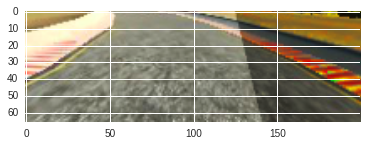

In [18]:
# This is a modified version of code created by Mez Gebre
# https://mez.github.io/deep%20learning/2017/02/14/mainsqueeze-the-52-parameter-model-that-drives-in-the-udacity-simulator/
def shift_img(image, random_shift):
    rows, cols = image.shape[0], image.shape[1]
    mat = np.float32([[1, 0, random_shift], [0, 1, 0]])
    return cv2.warpAffine(image, mat, (cols, rows))

def load_image(row):
    image = cv2.imread("./data/{0}".format(row.image.strip()))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = augment_brightness_camera_images(image)
    image = add_random_shadow(image)
    image = crop_top_and_bottom(image)    
    
    if(row.is_flipped):
        image = cv2.flip(image,1)
    if(row.is_shift): 
        image = shift_img(image, row.random_shift)  
    return image

# Test it
row = processed_log.iloc[0]
img = load_image(row)
print('image shape:', img.shape)
plt.figure(1)
plt.imshow(img)
plt.show()

# Step 3 - Creating a NVIDIA model

https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf


In [19]:
def my_nvidia():
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66,200,3)))
    model.add(Convolution2D(24,5,5,activation='relu', subsample=(2, 2), name='conv1-5x5'))
    model.add(Convolution2D(36,5,5,activation='relu', subsample=(2, 2), name='conv2-5x5'))
    model.add(Convolution2D(48,5,5,activation='relu', subsample=(2, 2), name='conv3-5x5'))
    model.add(Convolution2D(64,3,3,activation='relu', subsample=(1, 1), name='conv4-3x3'))
    model.add(Convolution2D(64,3,3,activation='relu', subsample=(1, 1), name='conv5-3x3'))
    model.add(Flatten())
    model.add(Dense(1164, activation='linear'))
    model.add(Dropout(.5))
    model.add(Dense(100, activation='linear'))
    model.add(Dropout(.2))
    model.add(Dense(50, activation='linear'))
    model.add(Dropout(.1))
    model.add(Dense(10, activation='linear'))
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer='adam')
    plot(model, to_file='my_nvidia.png', show_shapes=True)
    
    return model

model = my_nvidia()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
conv1-5x5 (Convolution2D)        (None, 31, 98, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
conv2-5x5 (Convolution2D)        (None, 14, 47, 36)    21636       conv1-5x5[0][0]                  
____________________________________________________________________________________________________
conv3-5x5 (Convolution2D)        (None, 5, 22, 48)     43248       conv2-5x5[0][0]                  
___________________________________________________________________________________________

# Step 4 - Image generator

I have decided to split train/validation in 80%/20%, and have used batch size of 256.

In [20]:
import sklearn

# Split the data for validation
df_train=processed_log.sample(frac=0.8) # shuffle and keep 80%
df_validation=processed_log.drop(df_train.index) # 20%
#print('processed_log shape: ', processed_log.shape)
#print('df_train shape: ', df_train.shape)
#print('df_validation shape: ', df_validation.shape)

def generator_features_and_labels(df, batch_size=32):
    num_samples = df.shape[0]
    #print('df shape: ', df.shape)
    #print('num_samples: ', num_samples)
    while 1: # Loop forever so the generator never terminates
        df = df.sample(frac=1).reset_index(drop=True) # shuffle the rows, reset indexes
        for offset in range(0, num_samples, batch_size):
            batch_samples = df.iloc[offset:offset+batch_size].reset_index(drop=True)
            
            images = [load_image(row) for _, row in batch_samples.iterrows()]
            X_train = np.array(images).reshape((len(images), 66, 200, 3))
            y_train = batch_samples.steering
            #print('X_train shape: ', X_train.shape)
            #print('y_train shape: ', y_train.shape)

            yield sklearn.utils.shuffle(X_train, y_train)

#test = list(generator_features_and_labels(df_train, batch_size=32))
train_generator = generator_features_and_labels(df_train, batch_size=256)
validation_generator = generator_features_and_labels(df_validation, batch_size=256)

# Step 5 - Training the model

After some experimentation I noted that for a loss around 0.02 the train and validation in general would start to diverge (overfitting), so I have used a early stop function.

Trained 5 epochs. The model worked great on 'fastest' mode of the Udacity simulator, even up to 30MPG speed target!! I let it run several complete cycles to be sure it was a stable solution. I have tried the 'fantastic' mode of simulator and it does great as well but still some 'drunk' drive at high speed of about 30MPG, but stays on the road all the time, the shadow augmentation really helped for this mode since the detail shadows projected on the road did not interfered with the driving experience.


## Early stop  at 0.02 loss

In [21]:
# code created by Mez Gebre
# https://mez.github.io/deep%20learning/2017/02/14/mainsqueeze-the-52-parameter-model-that-drives-in-the-udacity-simulator/
class CustomEarlyStop(Callback):
    """
    Custom Callback that stops the epoch when val_loss reachs user specified value
    This callback assumes you are logging val loss
    """
    def __init__(self, monitor='val_loss'):
        super(CustomEarlyStop, self).__init__()
        self.monitor = monitor
        
   
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get(self.monitor)
        if val_loss <= 0.02:
            print("\nEarly Stop on Epoch {0} with Val_loss {1}\n".format(epoch,val_loss))
            self.model.stop_training = True

## 5 epochs training

Epoch 1/5
10042/10042 [==============================] - 107s - loss: 0.0585 - val_loss: 0.0357

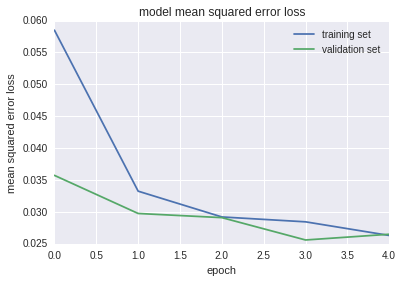

In [22]:
early_stop = CustomEarlyStop(monitor='val_loss')

history_object = model.fit_generator(train_generator, samples_per_epoch= \
            df_train.shape[0], validation_data=validation_generator, \
            nb_val_samples=df_validation.shape[0], nb_epoch=5, verbose=1, callbacks=[early_stop])

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

## Save and test the model

In [23]:
# Save model
model.save('model_track1.h5')

## Visualize Filters

image shape: (66, 200, 3)


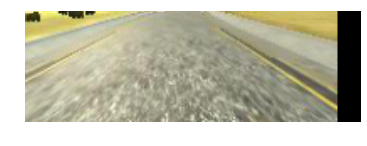

image shape: (1, 66, 200, 3)


In [24]:
# Load test image
index = np.random.randint(0, processed_log.shape[0])
row = processed_log.iloc[index]
img = load_image(row)
print('image shape:', img.shape)
plt.figure(1)
plt.axis('off')
plt.imshow(img)
plt.show()

# insert new dimension to use it
img = img[np.newaxis,:,:,:]
print('image shape:', img.shape)


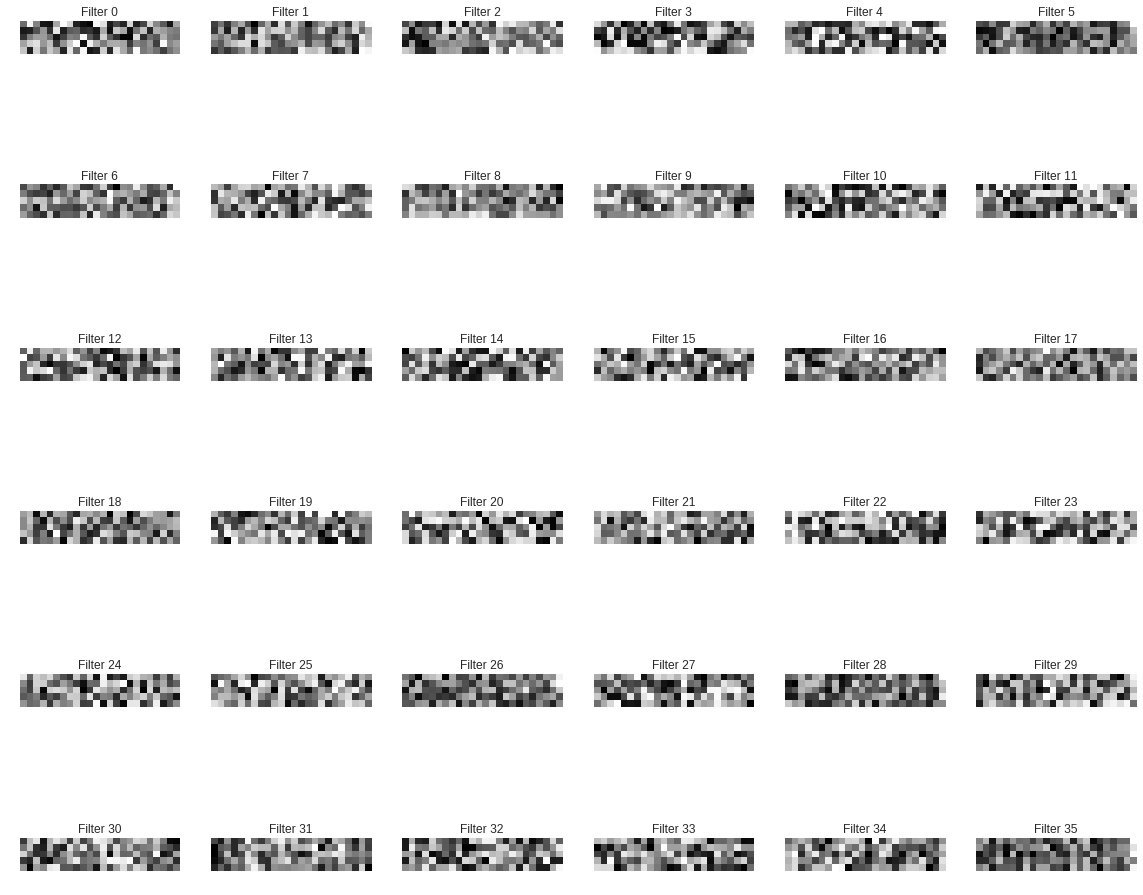

In [25]:
# code reference:
# https://medium.com/@awjuliani/visualizing-neural-network-layer-activation-tensorflow-tutorial-d45f8bf7bbc4#.t37fmyoee
import math
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.axis('off')
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

# Plot filters
filters = model.layers[2].get_weights()[0] # call only CNN layers
plotNNFilter(filters)